# O que é a Lei Rouanet

A Lei Rouanet, oficialmente denominada Lei 8.313/91, é o principal mecanismo de fomento à cultura no Brasil, instituindo o Programa Nacional de Apoio à Cultura (Pronac). Seu nome é uma homenagem ao seu idealizador, o diplomata Sérgio Paulo Rouanet, então secretário Nacional de Cultura. Essa legislação estabelece as diretrizes para o Governo Federal disponibilizar recursos destinados à realização de projetos artístico-culturais. Originalmente, a Lei Rouanet foi concebida com três mecanismos: o Fundo Nacional da Cultura (FNC), o Incentivo Fiscal e o Fundo de Investimento Cultural e Artístico (Ficart). No entanto, o Ficart nunca foi implementado, enquanto o Incentivo Fiscal, também conhecido como mecenato, se destacou e, muitas vezes, é erroneamente associado como sendo a própria Lei Rouanet.

###

# Sobre o projeto

Este projeto oferece a oportunidade de compreender melhor a distribuição de recursos culturais por meio da Lei Rouanet e extrair insights significativos sobre a diversidade e impacto dos projetos financiados. 

**Objetivo do projeto**

Realizar uma análise exploratória de dados (EDA) no conjunto de dados da Lei Rouanet (2009-2024), buscando compreender padrões, tendências e insights relacionados aos projetos culturais financiados por meio dessa lei de incentivo à cultura no Brasil.

## Passos do projeto

### 1. Coletar e Carregar os Dados

- Obter o dataset da Lei Rouanet, disponibilizado pelo Ministério da Cultura [(SALIC)](https://api.salic.cultura.gov.br/doc/)
- Carregar os dados em um DataFrame do pandas.

### 2. Realizar uma Exploração Inicial

- Fazer uma exploração inicial para entender a estrutura do dataset, tipos de variáveis e dados disponíveis.

### 3. Limpar e preparar os dados

- Tratar valores ausentes, inconsistências ou duplicatas.
- Analisar, criar e ajustar categorias relevantes.

### 4. Analisar

**4.1. Segmentação por áreas culturais**

- Classificar os projetos por categorias culturais (música, artes cênicas, audiovisual, etc.).
- Verificar a distribuição das áreas ao longo dos anos

**4.2. Participação geográfica**

- Visualizar a participação geográfica dos projetos. Qual região do Brasil recebeu mais incentivos culturais?

**4.3. Representividade sociocultural**

- Analisar se e como as minorias foram beneficiadas.

**4.4. Tipos de financiamento**

- Explorar os mecanismos de incentivo à cultura.
- Explorar os cálculos de isenção fiscal

**4.5. Distribuição de recursos**

- Analisar a dificuldade na captação de recursos.
- Analisar a distribuição de recursos por categoria.
- Analisar a distribuição de recursos por região.
- Explorar a distribuição de recursos financeiros ao longo do tempo.
- Identificar os projetos que receberam a maior e menor quantidade de financiamento.

**4.6. Influência de grandes projetos**

- Identificar e analisar grandes projetos que receberam um montante significativo de financiamento. Como esses projetos influenciam a distribuição geral?

**4.7. Recorte dos últimos anos**

- Refazer algumas análises anteriores considerando apenas os últimos X anos.

<!-- **4.8. Análise de sucesso**

- Definir critérios para o sucesso de um projeto (por exemplo, avaliação do público, impacto cultural) e explorar quais características estão associadas a projetos bem-sucedidos. -->

### 5. Concluir

- Resumir as principais descobertas do projeto.
- Identificar padrões interessantes, tendências ao longo do tempo e qualquer insight que possa ser valioso para as partes interessadas e tomadores de decisão.

## Ferramentas utilizadas

- Python (`pandas`, `numpy`, `geobr`, `matplotlib` e `seaborn`)
- Jupyter Notebook para documentação e visualização interativa.

###

# Análise de Dados Exploratória

<!-- Fontes:
- https://www.linkedin.com/pulse/entenda-o-que-%C3%A9-lei-rouanet-ficarte-fnc-e-oque-fiscal-oliveira/?originalSubdomain=pt
- https://www.gov.br/cultura/pt-br/centrais-de-conteudo/marcas-e-logotipos/copy_of_ManualdoProponenteMduloIApresentaodePropostas1.pdf
- https://portaldoincentivo.com.br/visitors/incentive_laws/1 -->

### 1. Coletar e Carregar os Dados

**Obter o dataset da Lei Rouanet, disponibilizado pelo Ministério da Cultura [(SALIC)](https://api.salic.cultura.gov.br/doc/)**

Eu desenvolvi um script utilizando as bibliotecas `os`, `request`, `json` e `pandas` para extrair os dados da API referentes aos projetos, propostas, proponentes, incentivadores e fornecedores. Os dados foram salvos em arquivos no formato `xsls`. Devido ao seu tamanho, não foi possível hospedá-los neste repositório. Em vez disso, eu os incluí em uma pasta no Google Drive e compartilhei os links em um arquivo `csv`. 

Esses arquivos podem ser baixados manualmente ou usando um script que criei com as bibliotecas `os` e `gdown`. 

**Carregar os dados em um DataFrame do pandas.**

In [1]:
from os import path

import numpy as np
import pandas as pd

import geobr
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_projetos = pd.read_excel(path.abspath("datasets/projetos.xlsx"))
df_proponentes = pd.read_excel(path.abspath("datasets/proponentes.xlsx"))
df_incentivadores = pd.read_excel(path.abspath("datasets/incentivadores.xlsx"))

####

### 2. Realizar uma Exploração Inicial

**Fazer uma exploração inicial para entender a estrutura do dataset, tipos de variáveis e dados disponíveis.**

In [3]:
df_projetos.columns

Index(['etapa', 'providencia', 'area', 'enquadramento', 'objetivos',
       'ficha_tecnica', 'situacao', 'outras_fontes', 'acessibilidade',
       'sinopse', 'nome', 'cgccpf', 'mecanismo', '_links', 'segmento',
       'PRONAC', 'estrategia_execucao', 'valor_aprovado', 'justificativa',
       'resumo', 'valor_solicitado', 'especificacao_tecnica', 'municipio',
       'data_termino', 'UF', 'impacto_ambiental', 'democratizacao',
       'valor_projeto', 'proponente', 'ano_projeto', 'data_inicio',
       'valor_captado', 'valor_proposta'],
      dtype='object')

Colunas interessantes para a análise dos **projetos**: 

- `providencia`
- `objetivos`
- `situacao`
- `area`
- `mecanismo`
- `enquadramento`
- `valor_aprovado`
- `valor_captado`
- `UF`
- `municipio`
- `ano_projeto`
- `data_termino`
- `data_inicio`

In [4]:
df_proponentes.columns

Index(['nome', 'cgccpf', '_links', 'tipo_pessoa', 'responsavel', 'UF',
       'total_captado', 'municipio'],
      dtype='object')

Colunas interessantes para a análise dos **proponentes**: 

- `tipo_pessoa`
- `responsavel`
- `UF`
- `municipio`
- `total_captado`

In [5]:
df_incentivadores.columns

Index(['nome', 'cgccpf', 'total_doado', '_links', 'tipo_pessoa', 'responsavel',
       'UF', 'municipio'],
      dtype='object')

Colunas interessantes para a análise dos **incentivadores**: 

- `nome`
- `tipo_pessoa`
- `total_doado`
- `UF`
- `municipio`

####

### 3. Limpar e preparar os dados

**Tratar valores ausentes, inconsistências ou duplicatas.**

Reduzindo os dfs para conter apenas as informações necessárias:

In [6]:
df_projetos = df_projetos[["providencia",
                     "objetivos",
                     "situacao",
                     "area",
                     "mecanismo",
                     "enquadramento",
                     "valor_aprovado",
                     "valor_captado",
                     "UF",
                     "municipio", 
                     "ano_projeto",
                     "data_termino",
                     "data_inicio"]].sort_values("UF")

df_proponentes = df_proponentes[["tipo_pessoa",
                           "responsavel",
                           "UF",
                           "municipio",
                           "total_captado"]].sort_values("UF")

df_incentivadores = df_incentivadores[["nome",
                                    "tipo_pessoa",
                                    "total_doado",
                                    "UF",
                                    "municipio"]].sort_values("UF")

In [7]:
# removendo linhas duplicadas
df_projetos.drop_duplicates(inplace=True)

In [8]:
# removendo projetos com todos os valores menores ou iguais a zero OU indeferidos ou arquivados
filtro_valor_aprovado_zerado = df_projetos["valor_aprovado"] <= 0
filtro_valor_captado_zerado = df_projetos["valor_captado"] <= 0
filtro_situacao_negativa = df_projetos["situacao"].str.lower().str.contains("|".join(["arquivado", "arquivamento", "indeferido", "inadimplen"]))
conjunto_filtros_negativos = ((filtro_valor_aprovado_zerado & filtro_valor_captado_zerado) | filtro_situacao_negativa)

# com exceção daqueles que tiveram captação acima de zero E foram encerrados normalmente
filtro_valor_captado_positivo = df_projetos["valor_captado"] > 0
filtro_situacao_positiva = df_projetos["situacao"].str.lower().str.contains("|".join(['captação/execução encerradas', "recursos transferidos"]))
conjuntos_filtros_positivos = filtro_valor_captado_positivo & filtro_situacao_positiva

df_projetos = df_projetos[~(conjunto_filtros_negativos ^ conjuntos_filtros_positivos)]

# existem somente 3 projetos arquivados com valor de captação maior que zero
# suas providências foram analisadas e confere o arquivamento
# teste[(teste["situacao"] == "Arquivado") & (teste["valor_captado"] > 0)]["providencia"].unique()

In [9]:
# remover coluna de providência e situação (não serão mais utilizadas)
df_projetos.drop("providencia", axis=1, inplace=True)
df_projetos.drop("situacao", axis=1, inplace=True)

In [10]:
# padronizando ano para formato 20XX
df_projetos["ano_projeto"] = 2000 + df_projetos["ano_projeto"]

In [11]:
# removendo datas inválidas
datas_invalidas = ["8201-08-28", "3204-03-31", "3015-01-31", "2424-12-31", "7014-10-10"]
filtro_data_termino_invalida = df_projetos["data_termino"].str.contains("|".join(datas_invalidas))

if filtro_data_termino_invalida.any(axis=None):
    for data in datas_invalidas:
        df_projetos.loc[df_projetos["data_termino"] == data, "data_termino"] = np.nan

In [12]:
# convertendo datas para datetime
df_projetos["data_inicio"] = pd.to_datetime(df_projetos["data_inicio"])
df_projetos["data_termino"] = pd.to_datetime(df_projetos["data_termino"])

In [13]:
# ajustando index após remoções
df_projetos.set_index(np.arange(0, df_projetos.shape[0]), inplace=True)

Tratamento dos dados dos proponentes:

In [14]:
uf_invalidos = ["  ", "35", "33", "41", "51", "15", "26", "53"]
df_proponentes = df_proponentes[~(df_proponentes["UF"].str.contains("|".join(uf_invalidos))) & ~(df_proponentes["responsavel"] == '.')]

Tratamento dos dados dos incentivadores:

In [15]:
uf_invalidos = ["  ", "13", "15", "17", "21", "22", "23", "25", "26", "27", "28", "29", "31", "32", "33", "35", "41", "42", "43", "50", "51", "52", "53", "NI"]
df_incentivadores = df_incentivadores[~df_incentivadores["UF"].str.contains("|".join(uf_invalidos))]

#####

**Analisar, criar e ajustar categorias relevantes.**

Dividir estados por regiões do Brasil:

In [16]:
def regiao_do_uf(uf):
    regioes = {
        "Centro Oeste": ["DF", "GO", "MS", "MT"],
        "Nordeste": ["AL", "BA", "CE", "MA", "PB", "PE", "PI", "RN", "SE"],
        "Norte": ["AC", "AM", "AP", "PA", "RO", "RR", "TO"],
        "Sudeste": ["ES", "MG", "RJ", "SP"],
        "Sul": ["PR", "RS", "SC"]
    }
    for regiao, estados in regioes.items():
        if uf in estados:
            return regiao

regioes = pd.Series(df_projetos["UF"].apply(regiao_do_uf), name="regiao")

if "regiao" not in df_projetos.columns:
    df_projetos = pd.concat([df_projetos, regioes], axis=1)

In [17]:
minorias = ["afro", "áfrica", "africa", "quilombola", "pessoas negras", "homem negro", "homem preto", "mulher negra", "mulher preta", "homens negros", "homens pretos", "mulheres negras", "mulheres pretas", 
            "índio", "indio", "povos originários", "povos originarios", "indígena", "indigena", "caiçara", 
            "baixa renda", "favela", "periferia", "pobre", "pessoas em situação de rua", "situação de vulnerabilidade", "mendigo",
            "mulher", "feminino",
            "homossex", "homofobia", "lgbt", "gay", "lésbica", "bissexua", "pessoas trans", "mulheres trans", "homens trans", "transsexua", "transgênero", "transgenero", "queer",
            "pcd", "deficiência", "deficiencia", "deficiente", 
            "idoso", "idosa", "maior idade",
            "imigrante", "cigano", "cigana", "refugiado",
            "minoria"
           ]

filtro1 = df_projetos["objetivos"].isnull()
filtro2 = df_projetos["objetivos"].str.lower().str.contains("|".join(minorias))

arr_falsos = np.array([False for _ in range(df_projetos.shape[0])])
voltado_para_minorias = pd.Series(arr_falsos, name="voltado_para_minorias")
voltado_para_minorias[df_projetos[~filtro1 & filtro2].index] = True

if "voltado_para_minorias" not in df_projetos.columns:
    df_projetos = pd.concat([df_projetos, voltado_para_minorias], axis=1)

In [18]:
df_projetos.drop("objetivos", axis=1, inplace=True)

In [19]:
data_inicio = pd.to_datetime(df_projetos["data_inicio"])
data_termino = pd.to_datetime(df_projetos["data_termino"])
duracao = pd.Series(data_termino - data_inicio, name="duracao_dias")

if "duracao_dias" not in df_projetos.columns:
    df_projetos = pd.concat([df_projetos, duracao], axis=1)

In [20]:
df_projetos

,area,mecanismo,enquadramento,valor_aprovado,valor_captado,UF,municipio,ano_projeto,data_termino,data_inicio,regiao,voltado_para_minorias,duracao_dias
0,Artes Visuais,Mecenato,Artigo 18,816720.30,0.00,AC,Jordão,2023,2026-01-05,2025-01-06,Norte,True,364 days
1,Humanidades,Mecenato,Artigo 18,1160842.21,0.00,AC,Rio Branco,2016,2018-12-31,2017-01-26,Norte,False,704 days
2,Música,Mecenato,Artigo 26,87406.00,0.00,AC,Rio Branco,2018,2022-12-31,2018-12-27,Norte,False,1465 days
3,Música,Mecenato,Artigo 26,234454.00,150000.00,AC,Rio Branco,2010,2011-07-31,2010-11-11,Norte,False,262 days
4,Patrimônio Cultural,Mecenato,Artigo 18,154125.40,0.00,AC,Rio Branco,2023,2024-11-30,2024-02-01,Norte,False,303 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48339,Patrimônio Cultural,Mecenato,Artigo 26,199856.25,0.00,TO,Palmas,2019,2023-12-31,2019-07-12,Norte,False,1633 days
48340,Música,Mecenato,Artigo 26,198955.72,0.00,TO,Araguaína,2018,2021-12-31,2018-08-27,Norte,False,1222 days
48341,Música,Mecenato,Artigo 26,199534.50,0.00,TO,Araguaína,2019,2022-12-31,2019-12-19,Norte,False,1108 days
48342,Artes Cênicas,Mecenato,Artigo 18,381916.15,381916.15,TO,Araguaína,2017,2020-12-31,2017-11-30,Norte,False,1127 days


####

### 4. Analisar

#### 4.1. Segmentação por áreas culturais

**Classificar os projetos por categorias culturais (música, artes cênicas, audiovisual, etc.).**

Inicialmente, realizei as contagens dos projetos segmentados por áreas.

In [200]:
distribuicao_areas_brasil = df_projetos["area"].value_counts()

areas_por_regiao = df_projetos.groupby("regiao")["area"].value_counts(sort=False)

areas = areas_por_regiao.index.get_level_values(1).unique()
regioes = areas_por_regiao.index.get_level_values(0).unique()
valores_areas_por_regiao = areas_por_regiao.values.reshape(5, 8)

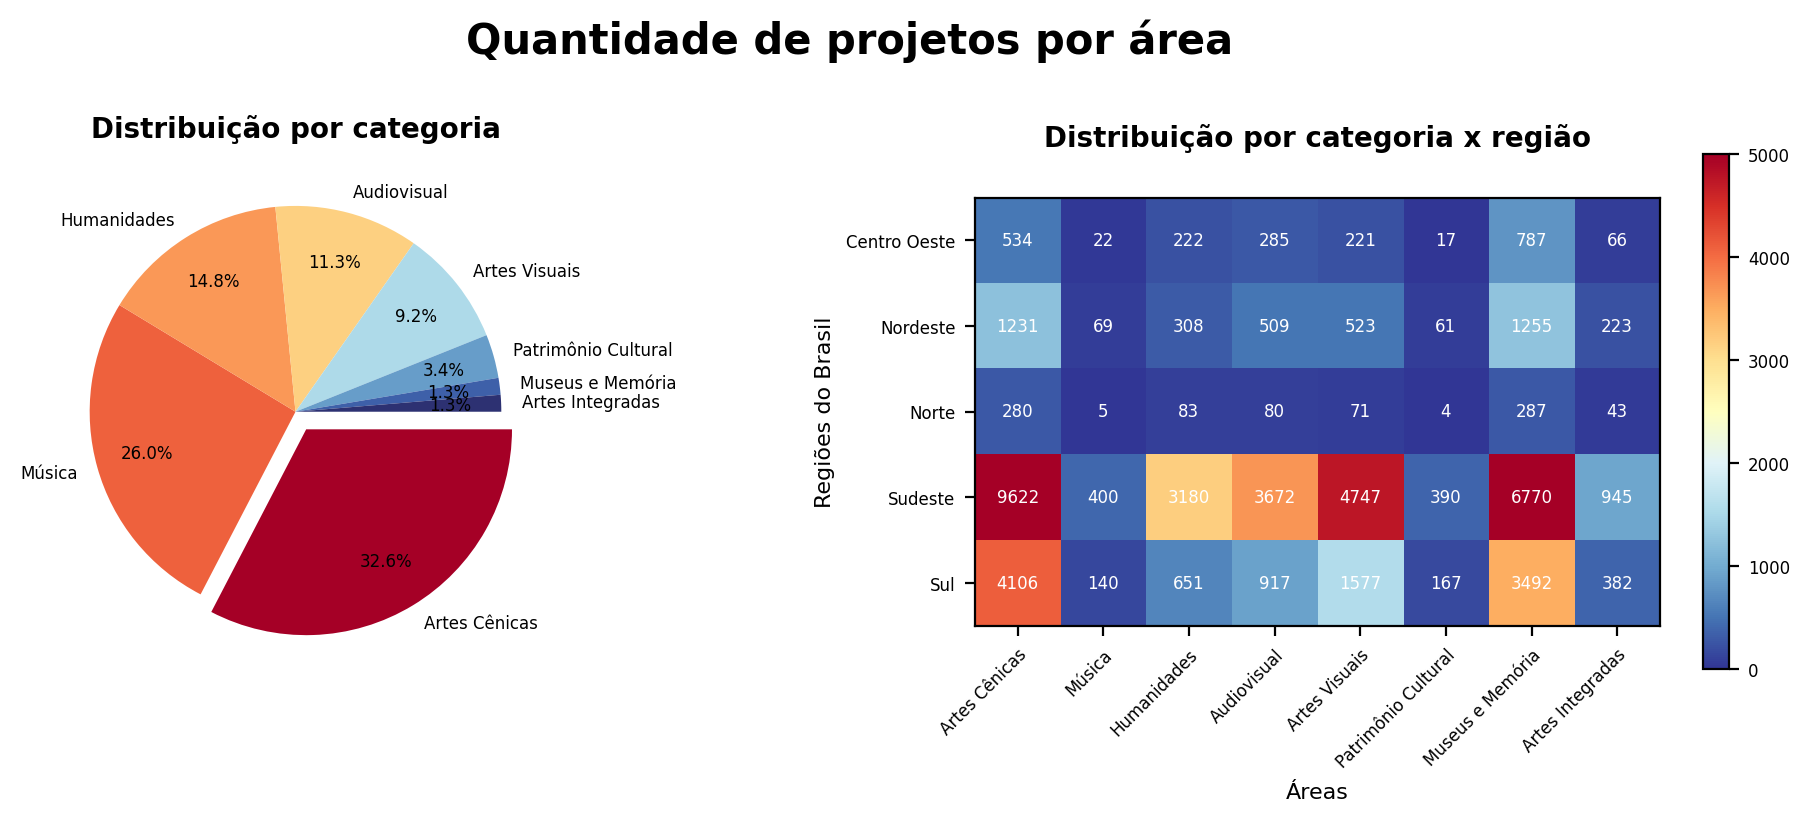

In [345]:
plt.rcParams.update({"font.size": 6})
cores = ["#A50026", "#EE613D", "#FA9857", "#FDD081", 
         "#AEDAE9", "#679DC9", "#3E60A9", "#2D3172"]
separacao_fatia = (0.1, 0, 0, 0, 0, 0, 0, 0)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=200)

ax1.pie(
    distribuicao_areas_brasil, 
    labels=distribuicao_areas_brasil.index, 
    autopct='%1.1f%%', 
    pctdistance=0.75,
    counterclock=False,
    colors=cores, 
    explode=separacao_fatia
)

heatmap = ax2.imshow(
    valores_areas_por_regiao,
    cmap="RdYlBu_r",
    vmin=0,
    vmax=5000
)

plt.setp(
    ax2.get_xticklabels(),
    rotation=45,
    ha="right",
    rotation_mode="anchor"
)

plt.colorbar(heatmap, ax=ax2)

for i in range(len(regioes)):
    for j in range(len(areas)):
        texto = ax2.text(
            j, i,
            valores_areas_por_regiao[i, j],
            ha="center",
            va="center",
            color="#fff"
        )

pos = ax2.get_position()
ax2.set_position([pos.x0, pos.y0-0.13, pos.width, pos.height])

ax2.set_xticks(np.arange(len(areas)), labels=areas)
ax2.set_yticks(np.arange(len(regioes)), labels=regioes)

ax2.set_xlabel("Áreas", fontsize=8)
ax2.set_ylabel("Regiões do Brasil", fontsize=8)

fig.suptitle('Quantidade de projetos por área', fontsize=15, fontweight=1000, y=1.02)
ax1.set_title('Distribuição por categoria', fontsize=10, fontweight=600)
ax2.set_title('Distribuição por categoria x região', fontsize=10, fontweight=600, y=1.08)

plt.tight_layout()
plt.show()

#####

**Verificar a distribuição das áreas ao longo dos anos.**

In [327]:
areas_por_anos = df_projetos.groupby("area")["ano_projeto"].value_counts(sort=False).rename("qtd_projetos")
areas_por_anos = areas_por_anos.to_frame()
areas_por_anos = areas_por_anos.unstack(level="area", fill_value=0)["qtd_projetos"]

ordenacao = areas_por_anos.values.sum(axis=0).argsort()

indices = areas_por_anos.index
colunas = areas_por_anos.columns.T[ordenacao[::-1]].T
valores = areas_por_anos.values.T[ordenacao[::-1]].T
areas_por_anos = pd.DataFrame(valores, index=indices, columns=colunas)

anos = areas_por_anos.index
areas = areas_por_anos.columns
medias = areas_por_anos.values.mean(axis=0)

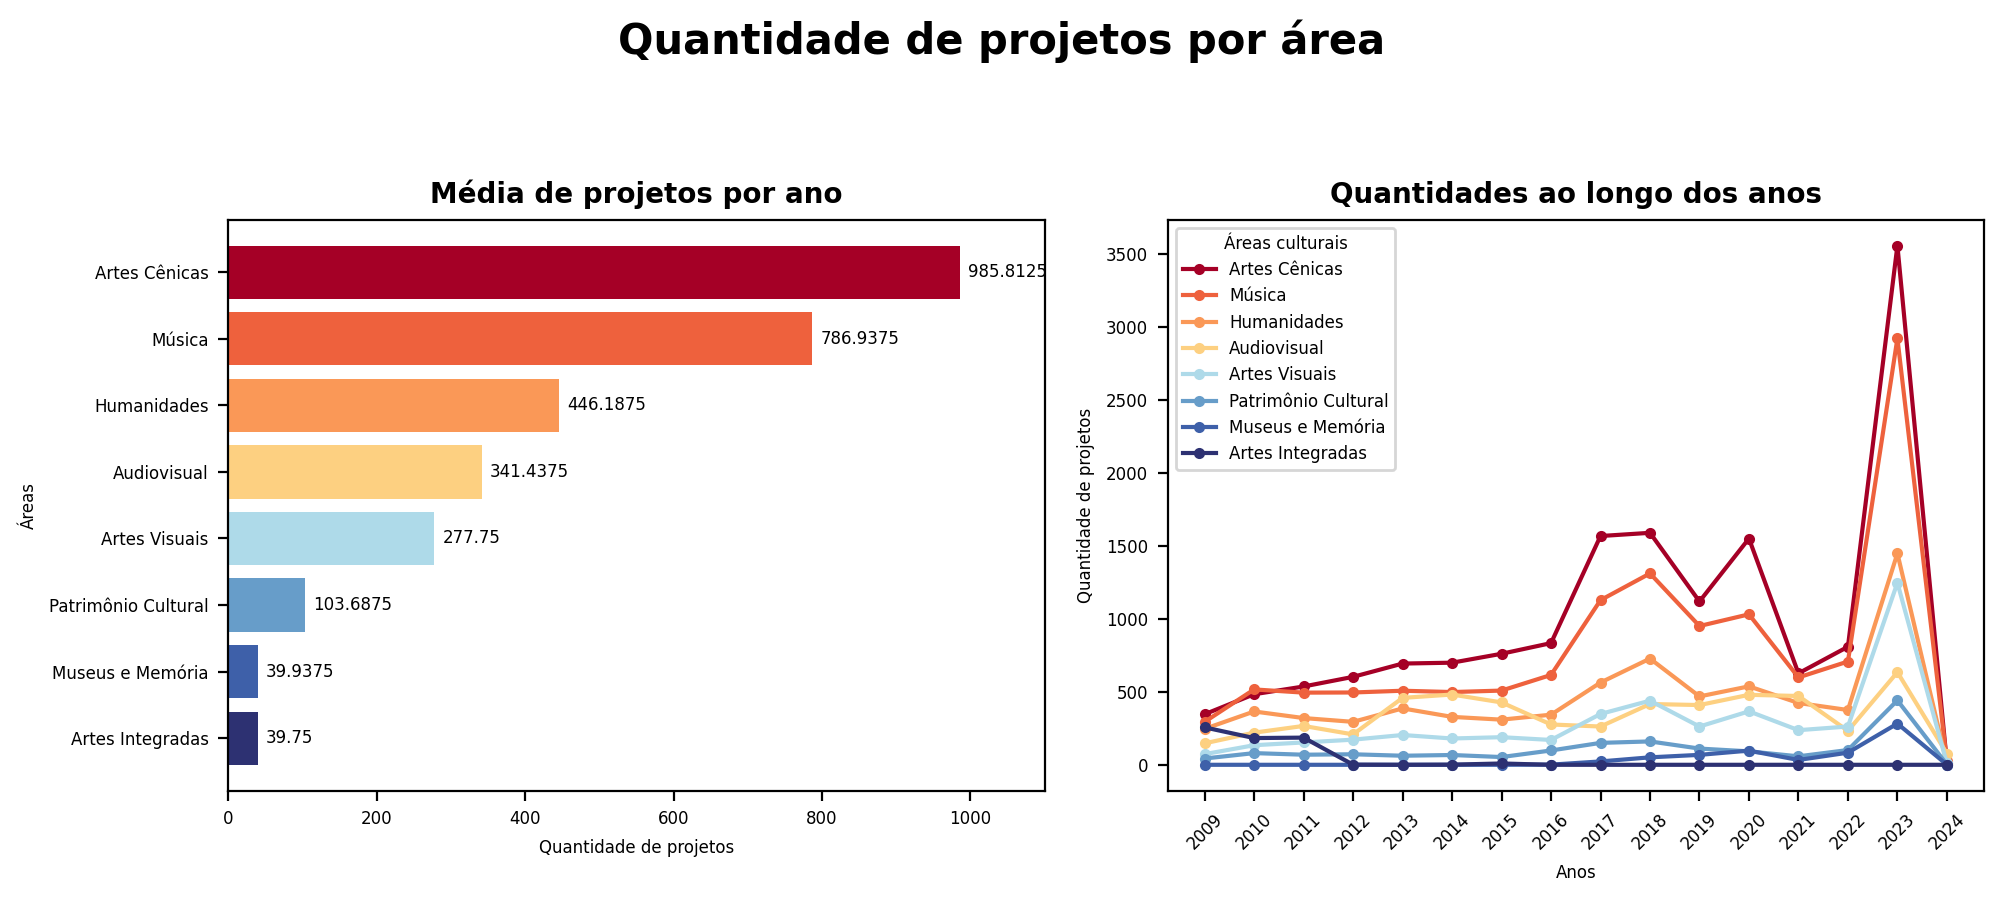

In [357]:
plt.rcParams.update({"font.size": 6})
cores = ["#A50026", "#EE613D", "#FA9857", "#FDD081", 
         "#AEDAE9", "#679DC9", "#3E60A9", "#2D3172"]
# separacao_fatia = (0.1, 0, 0, 0, 0, 0, 0, 0)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=200)

barras = ax1.barh(
    areas,
    medias,
    color=cores,
)

for barra in barras:
    comprimento = barra.get_width()
    ax1.annotate(
        text=f'{comprimento}',
        xy=(comprimento, barra.get_y() + barra.get_height() / 2),
        xytext=(3, 0),
        textcoords="offset points",
        va='center'
    )

ax1.invert_yaxis()

for i, qtd_projetos in enumerate(areas_por_anos.T.values):
    ax2.plot(
        anos,
        qtd_projetos,
        label=areas[i],
        color=cores[i],
        marker="o",
        markersize=3
    )

ax2.set_xticks(anos)
ax2.set_xticklabels(anos, rotation=45)

ax1.set_xlabel("Quantidade de projetos")
ax1.set_ylabel("Áreas")

ax2.set_xlabel("Anos")
ax2.set_ylabel("Quantidade de projetos")

ax2.legend(title="Áreas culturais")

plt.suptitle("Quantidade de projetos por área", fontsize=15, fontweight=1000, y=1.1)
ax1.set_title('Média de projetos por ano', fontsize=10, fontweight=600)
ax2.set_title('Quantidades ao longo dos anos', fontsize=10, fontweight=600)

ax1.set_xlim(0, 1100)

plt.tight_layout()
plt.show()

#####

**Verificar a duração média do projeto por categoria.**

In [ ]:
duracao_por_area = projetos.groupby("area")["duracao_dias"].mean().sort_values()
duracao_por_area

####

#### 4.2. Participação geográfica

**Visualizar a participação geográfica dos projetos.**

Inicialmente, realizei a contagem de projetos por regiões e por estados e plotei os resultados em um gráfico.

In [ ]:
warnings.filterwarnings("ignore")

projetos_por_regiao = projetos["regiao"].value_counts().rename("qtd_projetos")
regioes = geobr.read_region() # Download do mapa do Brasil dividido por regiões
regioes = regioes.merge(projetos_por_regiao, how="left", left_on="name_region", right_on="regiao")

projetos_por_estados = projetos["UF"].value_counts().rename("qtd_projetos")
estados = geobr.read_country(year=2020)  # Download do mapa do Brasil dividido por estados
estados = estados.merge(projetos_por_estados, how="left", left_on="abbrev_state", right_on="UF")

In [ ]:
plt.rcParams.update({"font.size": 6})

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), dpi=200)


def plot_mapa(mapa, axis):
    mapa.plot(
        column="qtd_projetos",
        cmap="RdYlBu_r",
        legend=True,
        legend_kwds={
            "label": "Quantidade de projetos",
            "orientation": "vertical",
            "shrink": 0.6,
        },
        ax=axis,
    )

    axis.axis("off")


plot_mapa(regioes, axs[0])
plot_mapa(estados, axs[1])

fig.suptitle('Projetos por localização', fontsize=12, fontweight=1000, y=0.95)
axs[0].set_title("Regiões do Brasil", fontsize=10, fontweight=600)
axs[1].set_title("Estados do Brasil", fontsize=10, fontweight=600)

plt.tight_layout()
plt.show()

In [ ]:
warnings.filterwarnings("default")

####

#### 4.3. Representividade sociocultural

**Analisar se e como as minorias foram beneficiadas.**

In [ ]:
warnings.filterwarnings("ignore")

projetos_minorias = projetos["voltado_para_minorias"].value_counts()


projetos_por_ano_minorias = projetos.groupby("ano_projeto")["voltado_para_minorias"].value_counts()
rotulos_anos = projetos_por_ano_minorias.index.get_level_values('ano_projeto')
rotulos_anos_geral, rotulos_anos_minorias = np.array(rotulos_anos).reshape(-1, 2).T
valores_anos_geral, valores_anos_minorias = projetos_por_ano_minorias.values.reshape(-1, 2).T

In [ ]:
plt.rcParams.update({"font.size": 6})
cores = ["#A50026", "#00b4d8"]
separacao_fatia = (0, 0.1)

fig, axs = plt.subplot_mosaic([['a)', 'b)'], ['a)', 'c)']], layout='constrained', figsize=(10, 4), dpi=200)

for i, (_, ax) in enumerate(axs.items(), 1):
    if i == 1:
        ax.pie(
            projetos_minorias,
            labels=["Geral", "Minorias sociais"],
            autopct="%1.1f%%",
            pctdistance=0.75,
            colors=cores,
            explode=separacao_fatia
        )
        
        ax.set_title("Distribuição dos projetos", fontsize=12, fontweight=600)
    elif i == 2:
        ax.plot(
            rotulos_anos_geral,
            valores_anos_geral,
            color=cores[0]
        )
        
        ax.set_title("Projetos para o público geral ao longo dos anos", fontsize=9, fontweight=600)
        
        ax.set_xlabel("Anos")
        ax.set_ylabel("Quantidade de projetos")

        ax.set_xticks(rotulos_anos_geral)
        
    else:
        ax.plot(
            rotulos_anos_minorias,
            valores_anos_minorias,
            color=cores[1]
        )
        
        ax.set_title("Projetos voltados para as minorias ao longo dos anos", fontsize=9, fontweight=600)

        ax.set_xlabel("Anos")
        ax.set_ylabel("Quantidade de projetos")

        ax.set_xticks(rotulos_anos_minorias)

plt.suptitle("Projetos com foco nos grupos minoritários", fontsize=15, fontweight=1000, y=1.05)

plt.tight_layout()

plt.show()

In [ ]:
minorias_por_area = projetos[projetos["voltado_para_minorias"] == True]["area"].value_counts().sort_values(ascending=False)
minorias_por_regiao = projetos[projetos["voltado_para_minorias"] == True]["regiao"].value_counts().rename("qtd_projetos")

regioes = geobr.read_region() # Download do mapa do Brasil dividido por regiões
regioes = regioes.merge(minorias_por_regiao, how="left", left_on="name_region", right_on="regiao")

In [ ]:
plt.rcParams.update({"font.size": 6})
cores = ["#A50026", "#EE613D", "#FA9857", "#FDD081", 
         "#AEDAE9", "#679DC9", "#3E60A9", "#313896"]
separacao_fatia_area = (0.1, 0, 0, 0, 0, 0, 0, 0)
separacao_fatia_regiao = (0.1, 0, 0, 0, 0)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=200)

ax1.pie(
    minorias_por_area,
    labels=minorias_por_area.index,
    autopct="%1.1f%%",
    pctdistance=0.75,
    counterclock=False,
    colors=cores,
    explode=separacao_fatia_area
)

regioes.plot(
        column="qtd_projetos",
        cmap="RdYlBu_r",
        legend=True,
        legend_kwds={
            "label": "Quantidade de projetos",
            "orientation": "vertical",
            "shrink": 0.6,
        },
        ax=ax2,
    )

ax2.axis("off")

fig.suptitle('Segmentação dos projetos para grupos minoritários', fontsize=12, fontweight=1000, y=1.02)
ax1.set_title('Por categoria', fontsize=10, fontweight=600)
ax2.set_title('Por região', fontsize=10, fontweight=600)

plt.tight_layout()
plt.show()

In [ ]:
warnings.filterwarnings("default")

####

#### 4.4. Tipos de financiamentos

**Explorar os mecanismos de incentivo à cultura.**

Sobre os mecanismos utilizados pela Lei Rouanet:

- Incentivo Fiscal (mecenato)

O incentivo é um mecanismo em que a União faculta às pessoas físicas ou jurídicas a opção pela aplicação de parcelas do Imposto sobre a Renda, a título de doações ou patrocínios, no apoio direto a projetos culturais aprovados pelo Ministério da Cultura. Ou seja: o Governo Federal oferece uma ferramenta para que a sociedade possa decidir aplicar parte do dinheiro de seus impostos em ações culturais. Desta maneira, o incentivo fiscal estimula a participação da iniciativa privada, do mercado empresarial e dos cidadãos no aporte de recursos para o campo da cultura, diversificando possibilidades de financiamento, ampliando o volume de recursos destinados ao setor, atribuindo a ele mais potência e mais estratégia econômica.

- Fundo Nacional da Cultura (FNC)

O Fundo Nacional da Cultura (FNC) representa o investimento direto do Estado no fomento à Cultura, já que o apoio a projetos decorre de recursos do orçamento da União dentre outras fontes, como 3% do valor bruto arrecado pelas loterias federais e doações. O apoio via FNC tem como objetivo promover a distribuição regional dos recursos de forma equilibrada e é voltado aos projetos com maior dificuldade de captação junto ao mercado.

**Filtros:**

In [ ]:
filtro_mecanismo_mecenato = projetos["mecanismo"] == "Mecenato"
filtro_mecanismo_fnc = projetos["mecanismo"] == "FNC"

filtro_enquadramento_artigo18 = projetos["enquadramento"] == "Artigo 18"
filtro_enquadramento_artigo26 = projetos["enquadramento"] == "Artigo 26"

**Análises:**

In [ ]:
mecanismos = projetos["mecanismo"].value_counts(normalize=True) * 100

mecenato_por_anos = projetos[filtro_mecanismo_mecenato]["ano_projeto"].value_counts().sort_index()
fnc_por_anos = projetos[filtro_mecanismo_fnc]["ano_projeto"].value_counts().sort_index()

In [ ]:
plt.rcParams.update({"font.size": 6})
cores = ["#A50026", "#313896"]
separacao_fatia = (0, 0.1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=200)

ax1.pie(
    mecanismos,
    labels=mecanismos.index,
    autopct="%1.2f%%",
    counterclock=False,
    colors=cores,
    explode=separacao_fatia
)

ax2.plot(
    mecenato_por_anos.index, 
    mecenato_por_anos, 
    cores[0],
    
    fnc_por_anos.index,
    fnc_por_anos,
    cores[1],
    
    marker="o",
    markersize=4
)


def rotulos_pontos(arr_index, arr, ax):
    for x, y in zip(arr_index, arr):
        rotulo = "{}".format(y)
        ax.annotate(
            rotulo,
            (x, y),
            textcoords="offset points",
            xytext=(0, 6),
            fontsize=4,
            ha='center'
        )


rotulos_pontos(mecenato_por_anos.index, mecenato_por_anos, ax2)
rotulos_pontos(fnc_por_anos.index, fnc_por_anos, ax2)

plt.suptitle("Mecanismos dos projetos", fontsize=15, fontweight=1000, y=1.05)
ax1.set_title("Distribuição dos projetos", fontsize=10, fontweight=600)
ax2.set_title("Mudança ao longo dos anos", fontsize=10, fontweight=600)

plt.xlabel("Anos")
plt.ylabel("Quantidade de projetos")

ax2.legend(["Mecenato", "FNC"])

plt.ylim(bottom=0, top=13000)

plt.tight_layout()
plt.show()

Ao longo dos anos, a maior fatia dos projetos foi financiada pelo mecenato, sendo que o financiamento pelo estado ocorreu em 27,7% dos projetos.

Curiosamente, as Artes Integradas, área que representa a maior quantidade de projetos no Brasil e suas respectivas regiões, tem a grande maioria de seus projetos financiados pelo Estado. Segundo os dados, além das Artes Integradas, apenas 1 outro projeto foi financiado com o mecanismo do FNC, na área de Audiovisual. O restante dos projetos foram financiados via mecenato. Este projeto de Audiovisual será considerado uma anomalia e descartado para esta análise.

In [ ]:
# por area
mecenatos_por_area = projetos[filtro_mecanismo_mecenato]["area"].value_counts().sort_values(ascending=False)
fnc_por_area = projetos[filtro_mecanismo_fnc]["area"].value_counts()

# por regiao
mecenato_por_regiao = projetos[filtro_mecanismo_mecenato]["regiao"].value_counts().sort_index()
fnc_por_regiao = projetos[filtro_mecanismo_fnc]["regiao"].value_counts().sort_index()

In [ ]:
plt.rcParams.update({"font.size": 6})
cores = ["#A50026", "#EE613D", "#FA9857", "#FDD081", 
         "#AEDAE9", "#679DC9", "#3E60A9", "#313896"]
cor_fnc = ["#0096c7"]
cores = ["#c9184a", "#0096c7"]
rotulos = mecenato_por_regiao.index
localizacao_rotulos = np.arange(len(rotulos))
largura = 0.35

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=200)

ax1.pie(
    mecenatos_por_area,
    labels=mecenatos_por_area.index,
    autopct="%1.1f%%",
    pctdistance=0.83,
    radius=1.2, 
    wedgeprops={"width": 0.5, "edgecolor": 'w'},
    colors=cores_mecenato
)

ax1.pie(
    fnc_por_area,
    labels=fnc_por_area.index,
    labeldistance=0,
    startangle=90,
    autopct="%1.3f%%",
    pctdistance=0.75,
    radius=0.8,
    wedgeprops={"width": 0.4, "edgecolor": 'w'},
    textprops={"ha": "center"},
    colors=cor_fnc
)


def plot_barra(localizacao, dados, rotulo, cor, ax):
    
    if localizacao == "esquerda":
        xco = localizacao_rotulos - largura / 2
    elif localizacao == "direita":
        xco = localizacao_rotulos + largura / 2
    
    barra = ax.bar(
        x=xco, 
        height=dados, 
        width=largura, 
        label=rotulo, 
        color=cor
    )

    return barra


def autolabel(barras, ax):
    for barra in barras:
        altura = barra.get_height()
        ax.annotate(
            text=f'{altura}',
            xy=(barra.get_x() + barra.get_width() / 2, altura),
            xytext=(0, 3),
            textcoords="offset points",
            ha='center',
            va='bottom'
        )


barras1 = plot_barra("esquerda", mecenato_por_regiao, "Mecenato", cores[0], ax2)
barras2 = plot_barra("direita", fnc_por_regiao, "FNC", cores[1], ax2)

autolabel(barras1, ax2)
autolabel(barras2, ax2)

fig.suptitle("Segmentação dos mecanismos por categoria e região", fontsize=15, fontweight=1000, y=0.95)
ax1.set_title("Mecanismos por categoria", fontsize=10, fontweight=600, y = 1.05)
ax2.set_title("Mecanismos por região", fontsize=10, fontweight=600, y = 1.05)

ax2.set_xlabel("Regiões do Brasil")
ax2.set_ylabel("Quantidade de projetos")

ax2.set_xticks(localizacao_rotulos)
ax2.set_xticklabels(rotulos)

ax2.legend(loc='upper right', bbox_to_anchor=(1, 1.25),
          fancybox=True, shadow=True, fontsize=8)

ax2.set_ylim(top=60000)

plt.tight_layout()
plt.show()

Em relação à divisão regional, percebe-se que os empresários financiam mais projetos no sul e sudeste (de forma expressiva). No Norte, o FNC ultrapassa o Incentivo Fiscal como mecanismo, enquanto no Nordeste e Centro Oeste ambos mecanismos estão em patamares próximos.

#####

**Explorar os cálculos de isenção fiscal**

Projetos aprovados no Artigo 18 da Lei Rouanet podem ser patrocinados com 100% de isenção fiscal, tanto por pessoa jurídica quanto física, enquanto projetos aprovados no Artigo 26 da Lei Rouanet oferecem os seguintes limites de isenção fiscal:

Pessoa Jurídica

- 40% do valor incentivado, no caso de doação.
- 30% do valor incentivado, no caso de patrocínio.

Pessoa Física

- 80% do valor incentivado, no caso de doação.
- 60% do valor incentivado, no caso de patrocínio.

Abeixo está uma relação sobre os projetos enquadrados

In [ ]:
artigo18 = projetos[filtro_enquadramento_artigo18]
artigo26 = projetos[filtro_enquadramento_artigo26]
enquadrados = pd.DataFrame([artigo18.shape[0], artigo26.shape[0]],
                           index=["Artigo 18", "Artigo 26"],
                           columns=["qtd_projetos"])
enquadrados = enquadrados.sort_values(by="qtd_projetos", ascending=False)
display(enquadrados)

In [ ]:
filtro_artigo26_com_captacao = artigo26["valor_captado"] != 0
filtro_artigo18_com_captacao = artigo18["valor_captado"] != 0

qtd_projetos_artigo26 = artigo26.shape[0]
qtd_projetos_artigo26_com_captacao = artigo26[filtro_artigo26_com_captacao].shape[0]

qtd_projetos_artigo18 = artigo18.shape[0]
qtd_projetos_artigo18_com_captacao = artigo18[filtro_artigo18_com_captacao].shape[0]

pct_captacao_artigo26 = qtd_projetos_artigo26_com_captacao / qtd_projetos_artigo26 * 100
pct_captacao_artigo18 = qtd_projetos_artigo18_com_captacao / qtd_projetos_artigo18 * 100

In [ ]:
plt.rcParams.update({"font.size": 6})
cores = ["#c9184a", "#0096c7"]
separacao_fatia = (0.1, 0.0)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=200)

pedacos = ax1.pie(
    enquadrados.values.flatten(),
    labels=enquadrados.index,
    autopct="%1.1f%%",
    pctdistance=0.75,
    colors=cores,
    explode=separacao_fatia
)

barras = ax2.bar(
    ["Artigo 18", "Artigo 26"],
    [pct_captacao_artigo18, pct_captacao_artigo26],
    width=0.5,
    color=cores
)

for i, barra in enumerate(barras):
    altura = barra.get_height()
    ax2.annotate(
        text=f'{altura:.2f}%',
        xy=(barra.get_x() + barra.get_width() / 2, altura),
        xytext=(0, 3),
        textcoords="offset points",
        ha='center',
        va='bottom'
    )

fig.suptitle("Enquadramentos dos projetos financiados pelo Mecenato", fontsize=15, fontweight=1000, y=1.05)

ax1.set_title("Distribuição dos projetos", fontsize=10, fontweight=600)
ax2.set_title("Projetos que tiveram captação de recursos*", fontsize=10, fontweight=600)

ax2.annotate(
    '*Em relação ao total de projetos com o mesmo tipo de enquadramento.',
    xy = (0, -0.1),
    xycoords='axes fraction',
    ha='left',
    va="center"
)


ax2.set_ylim(0, 50)
ax2.set_xlim(-0.5, 1.5)

plt.tight_layout()
plt.show()

In [ ]:
# calcular media de dinheiro incentivado pelo mecenato (não entra na isenção fiscal do Artigo 26)

####

#### 4.5. Distribuição de recursos

**Analisar a distribuição de recursos por categoria.**

In [ ]:
# copia_projetos = projetos.copy()

# ufs = np.sort(copia_projetos["UF"].unique())
# areas = np.sort(copia_projetos["area"].unique())
# mecanismos = np.sort(copia_projetos["mecanismo"].unique())

# copia_projetos["UF"] = copia_projetos["UF"].apply(lambda uf: np.where(ufs == uf)[0][0])
# copia_projetos["area"] = copia_projetos["area"].apply(lambda area: np.where(areas == area)[0][0])
# copia_projetos["mecanismo"] = copia_projetos["mecanismo"].apply(lambda mecanismo: np.where(mecanismos == mecanismo)[0][0])

# copia_projetos[["UF", "area", "valor_captado", "valor_aprovado", "mecanismo"]].corr()

In [ ]:
# areas mais lucrativas (maior valor captado - média por projeto)
# areas mais caras (maior valor aprovado - média por projeto)
# relacao entre valor aprovado e valor captado: quanto mais caro o projeto, mais dificil de captar os recursos?

# captacao_por_area = projetos.groupby("area")["valor_aprovado"].sum()
# valor_aprovado_por_area = projetos.groupby("area")["valor_aprovado"].sum()


filtro_valor_captado_maior_que_zero = projetos["valor_captado"] > 0
filtro_valor_aprovado_maior_que_zero = projetos["valor_aprovado"] > 0
correlacao_captado_aprovado = projetos[filtro_valor_captado_maior_que_zero & filtro_valor_aprovado_maior_que_zero][["ano_projeto", "valor_captado", "valor_aprovado"]]


projetos[filtro_valor_captado_maior_que_zero & filtro_valor_aprovado_maior_que_zero][["valor_captado", "valor_aprovado"]].corr()

In [ ]:
projetos[filtro_valor_captado_maior_que_zero & filtro_valor_aprovado_maior_que_zero].groupby("area")[["valor_captado", "valor_aprovado"]].corr()

In [ ]:
projetos[filtro_valor_captado_maior_que_zero & filtro_valor_aprovado_maior_que_zero].groupby("regiao")[["valor_captado", "valor_aprovado"]].corr()

#####

**Analisar a distribuição de recursos por região.**

#####

**Identificar os projetos que receberam a maior e menor quantidade de financiamento.**

#####

**Explorar a distribuição de recursos financeiros ao longo do tempo.**

####

#### 4.6. Influência de grandes projetos

**Identificar e analisar grandes projetos que receberam um montante significativo de financiamento. Como esses projetos influenciam a distribuição geral?**

####

#### 4.7. Recorte dos últimos anos

**Refazer algumas análises anteriores considerando apenas os últimos X anos.**

###

### 5. Concluir

**Resumir as principais descobertas do projeto.**

#####

**Identificar padrões interessantes, tendências ao longo do tempo e qualquer insight que possa ser valioso para as partes interessadas e tomadores de decisão.**